# TinyML – CWRU 12k DE Dataset: Step-by-Step Preprocessing Notebook

This notebook guides you from **scratch** to build a training-ready dataset (NumPy arrays) from the **Case Western Reserve University (CWRU) 12k Drive-End (DE)** bearing vibration data.

### What you'll do here
1. **Organize folders** and verify `.mat` files.
2. **Auto-generate `metadata.csv`** that maps each file to labels and load (rpm).
3. **Load signals from `.mat`** robustly and **segment** them into fixed windows.
4. **Build X, y datasets**, split into train/val/test, and **save to disk**.

### Prerequisites
- You have downloaded the following **16 files** (MVP set) from the CWRU 12k DE section and placed them into the folder tree indicated below:
  - **Normal (loads 0–3)**: 4 files (names vary, often numeric like `97.mat`–`100.mat` or `Normal_0.mat`–`Normal_3.mat`).
  - **Inner Race (0.021\")**: `IR021_0.mat`, `IR021_1.mat`, `IR021_2.mat`, `IR021_3.mat`.
  - **Ball (0.021\")**: `B021_0.mat`, `B021_1.mat`, `B021_2.mat`, `B021_3.mat`.
  - **Outer Race @6:00 (0.021\")**: `OR021@6_0.mat`, `OR021@6_1.mat`, `OR021@6_2.mat`, `OR021@6_3.mat`.

### Recommended folder structure
```
data/
  DE_12k/
    load_0_rpm1797/
      normal/
      inner_race/
      ball/
      outer_race_6/
    load_1_rpm1772/
      normal/
      inner_race/
      ball/
      outer_race_6/
    load_2_rpm1750/
      normal/
      inner_race/
      ball/
      outer_race_6/
    load_3_rpm1730/
      normal/
      inner_race/
      ball/
      outer_race_6/
```

> If your folder names differ (e.g., `load0`), the code below will still infer the load index and rpm where possible.


In [14]:
# 0) Imports & Config
from pathlib import Path
import re, csv
import numpy as np
import pandas as pd
import scipy.io as sio
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set your dataset root here (relative to this notebook)
DATA_ROOT = Path("data/DE_12k")

# Constants for 12k Drive-End set
RPM_BY_LOAD = {0: 1797, 1: 1772, 2: 1750, 3: 1730}
FS_HZ = 12000
SENSOR = "DE"

# Patterns for filename parsing
P_OR = re.compile(r"^OR(?P<diam>\d{3})@(?P<orient>6|3|12)_(?P<load>[0-3])$", re.IGNORECASE)
P_IR = re.compile(r"^IR(?P<diam>\d{3})_(?P<load>[0-3])$", re.IGNORECASE)
P_B  = re.compile(r"^B(?P<diam>\d{3})_(?P<load>[0-3])$", re.IGNORECASE)
P_LOADFOLDER = re.compile(r"load[_\-]?(?P<load>[0-3])", re.IGNORECASE)
P_RPMFOLDER  = re.compile(r"rpm[_\-]?(?P<rpm>\d+)", re.IGNORECASE)


In [15]:
# 1) (Optional) Create the folder structure if it doesn't exist yet
loads = [
    "load_0_rpm1797","load_1_rpm1772","load_2_rpm1750","load_3_rpm1730"
]
classes = ["normal","inner_race","ball","outer_race_6"]

for ld in loads:
    for cl in classes:
        (DATA_ROOT/ld/cl).mkdir(parents=True, exist_ok=True)

print(f"Folder tree ready under: {DATA_ROOT.resolve()}")


Folder tree ready under: C:\Users\Ravi Kumar\Desktop\TinyML Project\data\DE_12k


In [16]:
# 2) Verify .mat files are visible
mats = [p for p in DATA_ROOT.rglob("*") if p.suffix.lower()==".mat"]
print(f"Found {len(mats)} .mat files under {DATA_ROOT}")
for p in mats[:10]:
    print(" ", p)

if len(mats)==0:
    print("[!] No .mat files found. Make sure you downloaded and placed the files correctly.")


Found 16 .mat files under data\DE_12k
  data\DE_12k\load_0_rpm1797\ball\B021_0.mat
  data\DE_12k\load_0_rpm1797\inner_race\IR021_0.mat
  data\DE_12k\load_0_rpm1797\normal\97.mat
  data\DE_12k\load_0_rpm1797\outer_race_6\OR021@6_0.mat
  data\DE_12k\load_1_rpm1772\ball\B021_1.mat
  data\DE_12k\load_1_rpm1772\inner_race\IR021_1.mat
  data\DE_12k\load_1_rpm1772\normal\98.mat
  data\DE_12k\load_1_rpm1772\outer_race_6\OR021@6_1.mat
  data\DE_12k\load_2_rpm1750\ball\B021_2.mat
  data\DE_12k\load_2_rpm1750\inner_race\IR021_2.mat


In [18]:
# 3) Build metadata.csv from the files we find (robust to naming)
def infer_load_from_parents(p: Path):
    load, rpm = None, None
    for parent in p.parents:
        m = P_LOADFOLDER.search(parent.name)
        if m:
            load = int(m.group("load"))
        m2 = P_RPMFOLDER.search(parent.name)
        if m2:
            rpm = int(m2.group("rpm"))
        if load is not None and rpm is not None:
            break
    if load is not None and rpm is None:
        rpm = RPM_BY_LOAD.get(load)
    return load, rpm

def classify(stem: str):
    s = stem.lower()
    m = P_OR.match(stem)
    if m:
        return dict(label="OuterRace", fault_type="OR",
                    fault_diameter_in=float(f"0.{m.group('diam')}"),
                    orientation=m.group("orient"), load=int(m.group("load")))
    m = P_IR.match(stem)
    if m:
        return dict(label="InnerRace", fault_type="IR",
                    fault_diameter_in=float(f"0.{m.group('diam')}"),
                    orientation="", load=int(m.group("load")))
    m = P_B.match(stem)
    if m:
        return dict(label="Ball", fault_type="B",
                    fault_diameter_in=float(f"0.{m.group('diam')}"),
                    orientation="", load=int(m.group("load")))
    if s.startswith("normal") or s.isdigit():
        return dict(label="Normal", fault_type="Normal",
                    fault_diameter_in="", orientation="", load=None)
    return None

rows = []
for mat in [p for p in DATA_ROOT.rglob("*") if p.suffix.lower()==".mat"]:
    info = classify(mat.stem)
    if info is None:
        # Skip others
        continue
    load_from_folder, rpm_from_folder = infer_load_from_parents(mat)
    load = load_from_folder if load_from_folder is not None else info["load"]
    rpm = rpm_from_folder if rpm_from_folder is not None else (RPM_BY_LOAD.get(load) if load is not None else None)

    rows.append({
        "filepath": mat.as_posix(),
        "label": info["label"],
        "fault_type": info["fault_type"],
        "fault_diameter_in": info["fault_diameter_in"],
        "orientation": info["orientation"],
        "load_hp": load,
        "rpm": rpm,
        "sensor": SENSOR,
        "fs_hz": FS_HZ,
    })

meta_path = DATA_ROOT/"metadata.csv"
pd.DataFrame(rows).to_csv(meta_path, index=False)
print(f"[✓] Wrote {len(rows)} rows to {meta_path}")

if len(rows)>0:
    display(pd.read_csv(meta_path).head())


[✓] Wrote 16 rows to data\DE_12k\metadata.csv


,filepath,label,fault_type,fault_diameter_in,orientation,load_hp,rpm,sensor,fs_hz
0,data/DE_12k/load_0_rpm1797/ball/B021_0.mat,Ball,B,0.021,NaN,0,1797,DE,12000
1,data/DE_12k/load_0_rpm1797/inner_race/IR021_0.mat,InnerRace,IR,0.021,NaN,0,1797,DE,12000
2,data/DE_12k/load_0_rpm1797/normal/97.mat,Normal,Normal,NaN,NaN,0,1797,DE,12000
3,data/DE_12k/load_0_rpm1797/outer_race_6/OR021@...,OuterRace,OR,0.021,6.0,0,1797,DE,12000
4,data/DE_12k/load_1_rpm1772/ball/B021_1.mat,Ball,B,0.021,NaN,1,1772,DE,12000


In [25]:
from pathlib import Path
import pandas as pd
import numpy as np

META_PATH = Path(r"data/DE_12k/metadata.csv")

# Read so that empty cells stay as empty strings (not NaN):
meta = pd.read_csv(META_PATH, keep_default_na=False, dtype={'orientation':'object'})

# Ensure dtypes and fill empties consistently
meta['orientation'] = meta['orientation'].astype(str).replace({'nan': ''})  # if any stray 'nan' strings
meta['fault_diameter_in'] = pd.to_numeric(meta['fault_diameter_in'], errors='coerce').fillna(0.0)
meta['load_hp'] = pd.to_numeric(meta['load_hp'], errors='coerce').astype('Int64')
meta['rpm'] = pd.to_numeric(meta['rpm'], errors='coerce').astype('Int64')
meta['sensor'] = meta['sensor'].astype(str)
meta['fs_hz'] = pd.to_numeric(meta['fs_hz'], errors='coerce').astype('Int64')

# Confirm every file exists (Windows/Unix compatible)
from pathlib import Path
missing = meta[~meta['filepath'].apply(lambda p: Path(p).exists())]
print(f"Rows: {len(meta)}, Missing files: {len(missing)}")
if len(missing):
    display(missing[['filepath','label']].head())

# Save back with empty strings instead of NaN
meta.to_csv(META_PATH, index=False)
display(meta.head(8))


Rows: 16, Missing files: 0


,filepath,label,fault_type,fault_diameter_in,orientation,load_hp,rpm,sensor,fs_hz
0,data/DE_12k/load_0_rpm1797/ball/B021_0.mat,Ball,B,0.021,,0,1797,DE,12000
1,data/DE_12k/load_0_rpm1797/inner_race/IR021_0.mat,InnerRace,IR,0.021,,0,1797,DE,12000
2,data/DE_12k/load_0_rpm1797/normal/97.mat,Normal,Normal,0.000,,0,1797,DE,12000
3,data/DE_12k/load_0_rpm1797/outer_race_6/OR021@...,OuterRace,OR,0.021,6,0,1797,DE,12000
4,data/DE_12k/load_1_rpm1772/ball/B021_1.mat,Ball,B,0.021,,1,1772,DE,12000
5,data/DE_12k/load_1_rpm1772/inner_race/IR021_1.mat,InnerRace,IR,0.021,,1,1772,DE,12000
6,data/DE_12k/load_1_rpm1772/normal/98.mat,Normal,Normal,0.000,,1,1772,DE,12000
7,data/DE_12k/load_1_rpm1772/outer_race_6/OR021@...,OuterRace,OR,0.021,6,1,1772,DE,12000


In [19]:
# 4) Inspect a .mat file (keys) to confirm the variable naming
def show_mat_keys(path):
    d = sio.loadmat(path, squeeze_me=True, struct_as_record=False)
    keys = [k for k in d.keys() if not k.startswith("__")]
    print("Keys:", keys)
    return keys

# Example: change to any valid path from your metadata
if len(rows)>0:
    sample_path = rows[0]['filepath']
    print("Sample file:", sample_path)
    try:
        show_mat_keys(sample_path)
    except Exception as e:
        print("Couldn't read sample .mat (okay if files aren't present yet):", e)


Sample file: data/DE_12k/load_0_rpm1797/ball/B021_0.mat
Keys: ['X118_DE_time', 'X118_FE_time', 'X118_BA_time', 'X118RPM']


In [20]:
# 5) Robust loader for DE time signal from CWRU .mat files
import numpy as np

def load_de_signal_from_mat(path):
    d = sio.loadmat(path, squeeze_me=True, struct_as_record=False)
    # candidate keys that typically hold the DE time series
    candidates = [k for k in d.keys() if not k.startswith("__")]
    # Prioritize keys that contain 'DE' (drive end)
    de_like = [k for k in candidates if 'DE' in k.upper()]
    for k in de_like + candidates:
        arr = d[k]
        if isinstance(arr, np.ndarray):
            # flatten 1D
            a = np.asarray(arr).reshape(-1)
            # heuristic: valid signals typically have > 1000 samples
            if a.ndim==1 and a.size>1000:
                return a
    raise ValueError(f"Could not find DE time series in {path}")

# Quick smoke test (only if files exist):
try:
    if len(rows)>0:
        sig = load_de_signal_from_mat(rows[0]['filepath'])
        print("Loaded signal length:", len(sig))
except Exception as e:
    print("(Skip) Load test error (okay if files aren't present):", e)


Loaded signal length: 122571


In [21]:
# 6) Segmentation utilities
def segment_signal(signal, window_size=2048, step=None, max_windows=None):
    if step is None:
        step = window_size  # non-overlapping by default
    segs = []
    for start in range(0, len(signal)-window_size+1, step):
        segs.append(signal[start:start+window_size])
        if max_windows and len(segs)>=max_windows:
            break
    return np.stack(segs) if segs else np.empty((0, window_size))

def standardize(X):
    # per-window standardization to zero-mean unit-variance
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True) + 1e-8
    return (X - mu) / sd


# 7) Build dataset (X, y) from metadata
LABEL_MAP = {"Normal":0, "InnerRace":1, "Ball":2, "OuterRace":3}

def build_dataset(meta_csv=DATA_ROOT/"metadata.csv", window_size=2048, step=None, per_file_limit=None):
    df = pd.read_csv(meta_csv)
    X_list, y_list = [], []
    for _, row in df.iterrows():
        path = row['filepath']
        label_name = row['label']
        try:
            sig = load_de_signal_from_mat(path)
            segs = segment_signal(sig, window_size=window_size, step=step, max_windows=per_file_limit)
            if segs.size==0:
                continue
            X_list.append(segs)
            y_list.append(np.full((len(segs),), LABEL_MAP[label_name], dtype=np.int64))
        except Exception as e:
            print(f"[warn] Skipping {path}: {e}")
            continue
    if not X_list:
        raise RuntimeError("No segments created. Check your files and paths.")
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

# Example build (tweak per_file_limit to keep size manageable in early tests)
try:
    # per_file_limit=None uses all; set e.g., 200 for quick runs
    X, y = build_dataset(per_file_limit=200)
    print("Shapes:", X.shape, y.shape)
except Exception as e:
    print("(Skip) Build error (okay if files aren't present yet):", e)


# 8) Train/Val/Test split and save
def save_splits(X, y, out_dir=DATA_ROOT/"npz", test_size=0.2, val_size=0.2, random_state=42):
    out_dir.mkdir(parents=True, exist_ok=True)
    # first split train+val vs test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    # split train vs val
    val_ratio = val_size / (1.0 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=val_ratio, random_state=random_state, stratify=y_trainval
    )
    np.savez_compressed(out_dir/"train.npz", X=X_train, y=y_train)
    np.savez_compressed(out_dir/"val.npz",   X=X_val,   y=y_val)
    np.savez_compressed(out_dir/"test.npz",  X=X_test,  y=y_test)
    print(f"Saved splits to {out_dir}")
    return (X_train, y_train, X_val, y_val, X_test, y_test)

try:
    # If X,y exist from previous cell
    _ = save_splits(X, y)
except Exception as e:
    print("(Skip) Save splits error (okay if X,y not built yet):", e)


In [26]:
import numpy as np
import pandas as pd
import scipy.io as sio
from sklearn.model_selection import train_test_split
from pathlib import Path

DATA_ROOT = Path("data/DE_12k")
META = pd.read_csv(DATA_ROOT/"metadata.csv", keep_default_na=False)

LABEL_MAP = {"Normal":0,"InnerRace":1,"Ball":2,"OuterRace":3}
WIN = 2048
STEP_TRAINVAL = 512   # overlap for train/val
STEP_TEST      = 2048 # no overlap for test

def load_de_signal_from_mat(path):
    d = sio.loadmat(path, squeeze_me=True, struct_as_record=False)
    keys = [k for k in d.keys() if not k.startswith("__")]
    # prefer keys containing 'DE'
    de_keys = [k for k in keys if "DE" in k.upper()] + keys
    for k in de_keys:
        arr = np.asarray(d[k]).reshape(-1)
        if arr.ndim == 1 and arr.size > 1000:
            return arr
    raise ValueError(f"DE signal not found in {path}")

def segment(sig, win, step):
    out = []
    for i in range(0, len(sig)-win+1, step):
        out.append(sig[i:i+win])
    return np.stack(out) if out else np.empty((0,win))

# keep only our four labels
META = META[META["label"].isin(LABEL_MAP.keys())].copy()
META["file_id"] = META["filepath"].apply(lambda p: Path(p).stem)
META["y_cls"] = META["label"].map(LABEL_MAP)

# split by FILE within each class (ensures all classes present in each split)
train_files, val_files, test_files = [], [], []
for cls, g in META.groupby("y_cls"):
    files = g["file_id"].unique()
    f_trainval, f_test = train_test_split(files, test_size=0.20, random_state=42)
    f_train, f_val = train_test_split(f_trainval, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2
    train_files += list(f_train)
    val_files   += list(f_val)
    test_files  += list(f_test)

train_set = META[META.file_id.isin(train_files)]
val_set   = META[META.file_id.isin(val_files)]
test_set  = META[META.file_id.isin(test_files)]

def build_from_filelist(df, step):
    X_list, y_list = [], []
    for _, row in df.iterrows():
        sig = load_de_signal_from_mat(row["filepath"])
        segs = segment(sig, WIN, step)
        if segs.size == 0: 
            continue
        # per-window standardize
        mu = segs.mean(axis=1, keepdims=True)
        sd = segs.std(axis=1, keepdims=True) + 1e-8
        segs = ((segs - mu)/sd).astype("float32")
        X_list.append(segs)
        y_list.append(np.full((len(segs),), row["y_cls"], dtype=np.int64))
    if not X_list:
        return np.empty((0,WIN),dtype="float32"), np.empty((0,),dtype="int64")
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

X_train, y_train = build_from_filelist(train_set, STEP_TRAINVAL)
X_val,   y_val   = build_from_filelist(val_set,   STEP_TRAINVAL)
X_test,  y_test  = build_from_filelist(test_set,  STEP_TEST)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Train per class:", np.bincount(y_train, minlength=4))
print("Val   per class:", np.bincount(y_val,   minlength=4))
print("Test  per class:", np.bincount(y_test,  minlength=4))

OUT = DATA_ROOT/"npz"
OUT.mkdir(parents=True, exist_ok=True)
np.savez_compressed(OUT/"train.npz", X=X_train, y=y_train)
np.savez_compressed(OUT/"val.npz",   X=X_val,   y=y_val)
np.savez_compressed(OUT/"test.npz",  X=X_test,  y=y_test)
print("Saved splits to:", OUT)


Shapes: (2822, 2048) (1652, 2048) (413, 2048)
Train per class: [1415  468  470  469]
Val   per class: [945 237 234 236]
Test  per class: [236  59  59  59]
Saved splits to: data\DE_12k\npz


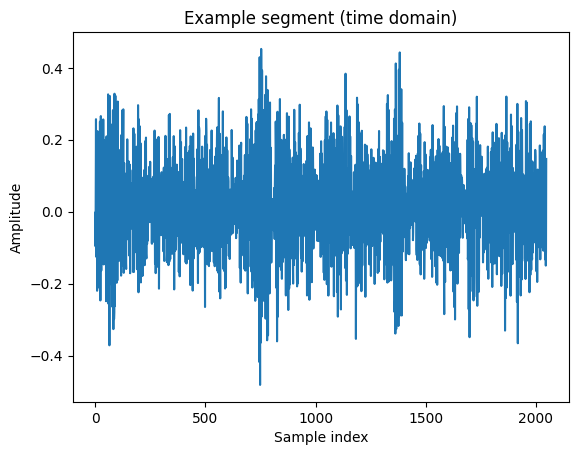

In [27]:
# 9) Quick visual check of one window (optional)
try:
    # Plot first segment to visually inspect. (No specific colors/styles per instruction.)
    plt.figure()
    plt.plot(X[0])
    plt.title("Example segment (time domain)")
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude")
    plt.show()
except Exception as e:
    print("(Skip) Plot error (okay if X not defined yet):", e)


In [28]:
from pathlib import Path
root = Path("data/DE_12k/npz")
print(root.exists(), list(root.glob("*.npz")))


True [WindowsPath('data/DE_12k/npz/test.npz'), WindowsPath('data/DE_12k/npz/train.npz'), WindowsPath('data/DE_12k/npz/val.npz')]


## Next steps
- Train a baseline classifier (e.g., Logistic Regression or a small 1D CNN) on `train.npz`.
- Evaluate accuracy/F1 on `val.npz` and `test.npz`.
- Optimize (quantization-aware training or post-training quantization) and export to **TensorFlow Lite Micro** for TinyML deployment.

You can create a new notebook `02_train_model.ipynb` that loads `npz/train.npz` etc. and builds a baseline.
